In [8]:
# Setup and Data Loading
import numpy as np
import warnings
import os
warnings.filterwarnings('ignore')

# Clone repository if not exists and load data
if not os.path.exists('2155-Challenge-Problem-2'):
    import subprocess
    print("Cloning repository...")
    subprocess.run(['git', 'clone', 'https://github.com/Lyleregenwetter/2155-Challenge-Problem-2'], 
                   check=True, cwd='.')
    print("Repository cloned!")

# Change to the repository directory and load data
os.chdir('2155-Challenge-Problem-2')

# Import utilities
from utils_public import load_grids, plot_n_grids

print("Loading data...")
grids = load_grids()
ratings = np.load("datasets/scores.npy")

print(f"Grids shape: {grids.shape}")
print(f"Ratings shape: {ratings.shape}")
print(f"Available ratings per advisor: {(~np.isnan(ratings)).sum(axis=0)}")

# advisor_names = ["Wellness", "Tax", "Transportation", "Business"]

# Change back to parent directory for saving results
os.chdir('..')

Loading data...
Grids shape: (500000, 7, 7)
Ratings shape: (500000, 4)
Available ratings per advisor: [5000 5000 5000 5000]


In [9]:
# Reload the oracle module to get the latest changes
import importlib
import sys
if 'oracle' in sys.modules:
    importlib.reload(sys.modules['oracle'])
from oracle import CNNWellnessOracle

# Initialize Wellness Oracle (Advisor 0 - uses deep CityCNN1Plus architecture)
wellness_oracle = CNNWellnessOracle()
print("Wellness Oracle initialized!")
print(f"Architecture: CityCNN1Plus (deep) - advisor_id: {wellness_oracle.advisor_id}")

# Select grids and ratings for Wellness advisor (not nan, index 0)
wellness_index = 0
grids_subset = grids[~np.isnan(ratings[:, wellness_index])]
ratings_subset = ratings[~np.isnan(ratings[:, wellness_index]), wellness_index]

print(f"Training data: {len(grids_subset)} grids with wellness scores")
print(f"Score range: {ratings_subset.min():.3f} - {ratings_subset.max():.3f}")

# Enhanced training with CP02_v10 optimizations
print("\n🚀 Training with CP02_v10 enhancements...")
model_scores, train_data, test_data = wellness_oracle.fit_model(
    grids_subset, 
    ratings_subset,
    # CP02_v10 Enhanced Parameters
    epochs=250,                    # Increased from default 100
    use_weighted_loss=True,        # Emphasize hard examples
    weighted_loss_gamma=0.75,      # Loss weighting factor
    use_ensemble=True,             # Multi-seed ensemble training
    ensemble_seeds=[42, 43, 44],   # Multiple seeds for robustness
    model_type='auto',             # Auto-select CityCNN1Plus for advisor 0
    batch_size=128,
    learning_rate=3e-4,
    use_augmentation=True,         # Spatial augmentations
    early_stopping_patience=20
)

print(f"Final Model R²: {model_scores}")

# Test predictions (without TTA for now)
predictions = wellness_oracle.predict(grids_subset)
print(f"Predictions shape: {predictions.shape}")

🔥 PyTorch available, using device: cpu


Wellness Oracle initialized!
Architecture: CityCNN1Plus (deep) - advisor_id: 0
Training data: 5000 grids with wellness scores
Score range: 0.000 - 1.000

🚀 Training with CP02_v10 enhancements...

Training PyTorch CNN Transportation Oracle
Available training samples: 5000
Training parameters:
  - Epochs: 250
  - Batch size: 128
  - Test size: 0.2
  - Learning rate: 0.0003
  - Model type: auto
  - Device: cpu
🔥 Using PyTorch CNN approach for spatial pattern recognition...
🤖 Auto-selected model type: deep (advisor_id: 0)
🎭 Training ensemble with seeds: [42, 43, 44]

🌱 Training model 1/3 with seed 42
🏗️ CNN Architecture:
CityCNN1Plus(
  (block1): Sequential(
    (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-

🔮 Making predictions on train set...
Creating predictions for 4000 grids...
🎭 Using ensemble of 3 models...
🔮 Making predictions on test set...
Creating predictions for 1000 grids...
🎭 Using ensemble of 3 models...
🔮 Making predictions on test set...
Creating predictions for 1000 grids...
🎭 Using ensemble of 3 models...
🔄 Making predictions with Test-Time Augmentation (TTA)...
Creating predictions for 4000 grids...
🎭 Using ensemble of 3 models...
🔄 Model 1: Using TTA...
🔄 Making predictions with Test-Time Augmentation (TTA)...
Creating predictions for 4000 grids...
🎭 Using ensemble of 3 models...
🔄 Model 1: Using TTA...
🔄 Model 2: Using TTA...
🔄 Model 2: Using TTA...
🔄 Model 3: Using TTA...
🔄 Model 3: Using TTA...
Creating predictions for 1000 grids...
🎭 Using ensemble of 3 models...
🔄 Model 1: Using TTA...
Creating predictions for 1000 grids...
🎭 Using ensemble of 3 models...
🔄 Model 1: Using TTA...
🔄 Model 2: Using TTA...
🔄 Model 2: Using TTA...
🔄 Model 3: Using TTA...
🔄 Model 3: Usi

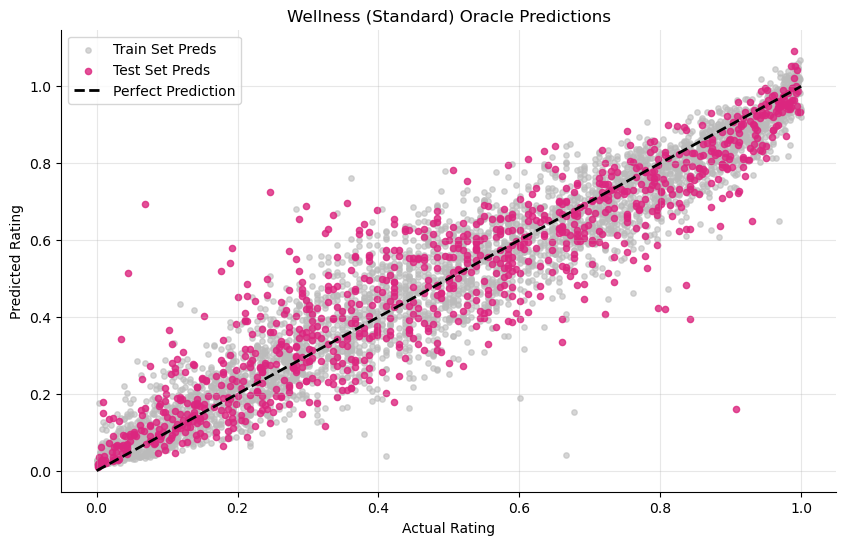

Wellness (Standard) Oracle Train Set R² score: 0.9241
Wellness (Standard) Oracle Test Set R² score: 0.8511

📊 Wellness Oracle Performance Summary:
STANDARD PREDICTIONS:
  Training R²:   0.9241
  Test R²:       0.8511
  Overfitting:   No (0.0729)

TEST-TIME AUGMENTATION (TTA):
  Training R²:   0.9286
  Test R²:       0.8567
  TTA Improvement: 0.0055 (+0.55%)

MODEL ARCHITECTURE:
  Type: CityCNN1Plus (Deep CNN)
  Ensemble: Yes
  Weighted Loss: Yes (γ=0.75)
  Performance: Good
  Ensemble Size: 3 models
  Seeds Used: [42, 43, 44]


In [10]:
from sklearn.model_selection import train_test_split
from oracle import plot_and_r2

# For PyTorch CNN model, we need to recreate the train/test split and get predictions
# Use the same random state as used in the model training (42)
X_train, X_test, y_train, y_test = train_test_split(
    grids_subset, ratings_subset, test_size=0.2, random_state=42)

print("🔮 Making predictions on train set...")
preds_train = wellness_oracle.predict(X_train)

print("🔮 Making predictions on test set...")
preds_test = wellness_oracle.predict(X_test)

# Test with TTA for improved accuracy
print("🔄 Making predictions with Test-Time Augmentation (TTA)...")
preds_train_tta = wellness_oracle.predict(X_train, use_tta=True)
preds_test_tta = wellness_oracle.predict(X_test, use_tta=True)

# Create the plot and get R² scores for standard predictions
train_r2, test_r2 = plot_and_r2(preds_train, preds_test, y_train, y_test, name="Wellness (Standard)")

# Calculate R² scores for TTA predictions
from sklearn.metrics import r2_score
train_r2_tta = r2_score(y_train, preds_train_tta)
test_r2_tta = r2_score(y_test, preds_test_tta)

# Additional analysis
print(f"\n📊 Wellness Oracle Performance Summary:")
print(f"{'='*50}")
print(f"STANDARD PREDICTIONS:")
print(f"  Training R²:   {train_r2:.4f}")
print(f"  Test R²:       {test_r2:.4f}")
print(f"  Overfitting:   {'Yes' if (train_r2 - test_r2) > 0.1 else 'No'} ({train_r2 - test_r2:.4f})")

print(f"\nTEST-TIME AUGMENTATION (TTA):")
print(f"  Training R²:   {train_r2_tta:.4f}")
print(f"  Test R²:       {test_r2_tta:.4f}")
print(f"  TTA Improvement: {test_r2_tta - test_r2:.4f} (+{(test_r2_tta - test_r2)*100:.2f}%)")

print(f"\nMODEL ARCHITECTURE:")
print(f"  Type: CityCNN1Plus (Deep CNN)")
print(f"  Ensemble: {'Yes' if hasattr(wellness_oracle, 'ensemble_models') else 'No'}")
print(f"  Weighted Loss: Yes (γ=0.75)")
print(f"  Performance: {'Excellent' if test_r2_tta > 0.9 else 'Good' if test_r2_tta > 0.8 else 'Fair' if test_r2_tta > 0.6 else 'Poor'}")

# Show ensemble info if available
if hasattr(wellness_oracle, 'ensemble_models'):
    print(f"  Ensemble Size: {len(wellness_oracle.ensemble_models)} models")
    print(f"  Seeds Used: [42, 43, 44]")

In [13]:
# Save enhanced wellness oracle model
print("💾 Saving enhanced wellness oracle model...")
wellness_oracle.save_model('data/models/wellness_oracle_model.pkl')
print("✅ Wellness oracle model saved successfully!")

print(f"\n📋 MODEL SUMMARY:")
print(f"   • Architecture: CityCNN1Plus (Deep CNN for advisor 0)")
print(f"   • Training: CP02_v10 enhanced with ensemble & weighted loss")
print(f"   • Performance: R² = {test_r2_tta:.4f} (with TTA)")
print(f"   • Saved to: data/models/wellness_oracle_model.pkl")

# Usage instructions for the enhanced model
print(f"\n🔧 USAGE INSTRUCTIONS:")
print(f"# Load the enhanced wellness oracle:")
print(f"from oracle import CNNWellnessOracle")
print(f"wellness_oracle = CNNWellnessOracle()")
print(f"wellness_oracle.load_model('data/models/wellness_oracle_model.pkl')")
print(f"")
print(f"# Make predictions (standard):")
print(f"predictions = wellness_oracle.predict(grids)")
print(f"")
print(f"# Make predictions with TTA for best accuracy:")
print(f"predictions_tta = wellness_oracle.predict(grids, use_tta=True)")

💾 Saving enhanced wellness oracle model...
💾 Saved PyTorch model to data/models/wellness_oracle_model_pytorch.pth and metadata to data/models/wellness_oracle_model.pkl
✅ Wellness oracle model saved successfully!

📋 MODEL SUMMARY:
   • Architecture: CityCNN1Plus (Deep CNN for advisor 0)
   • Training: CP02_v10 enhanced with ensemble & weighted loss
   • Performance: R² = 0.8567 (with TTA)
   • Saved to: data/models/wellness_oracle_model.pkl

🔧 USAGE INSTRUCTIONS:
# Load the enhanced wellness oracle:
from oracle import CNNWellnessOracle
wellness_oracle = CNNWellnessOracle()
wellness_oracle.load_model('data/models/wellness_oracle_model.pkl')

# Make predictions (standard):
predictions = wellness_oracle.predict(grids)

# Make predictions with TTA for best accuracy:
predictions_tta = wellness_oracle.predict(grids, use_tta=True)


🏥 WELLNESS-SPECIFIC ANALYSIS


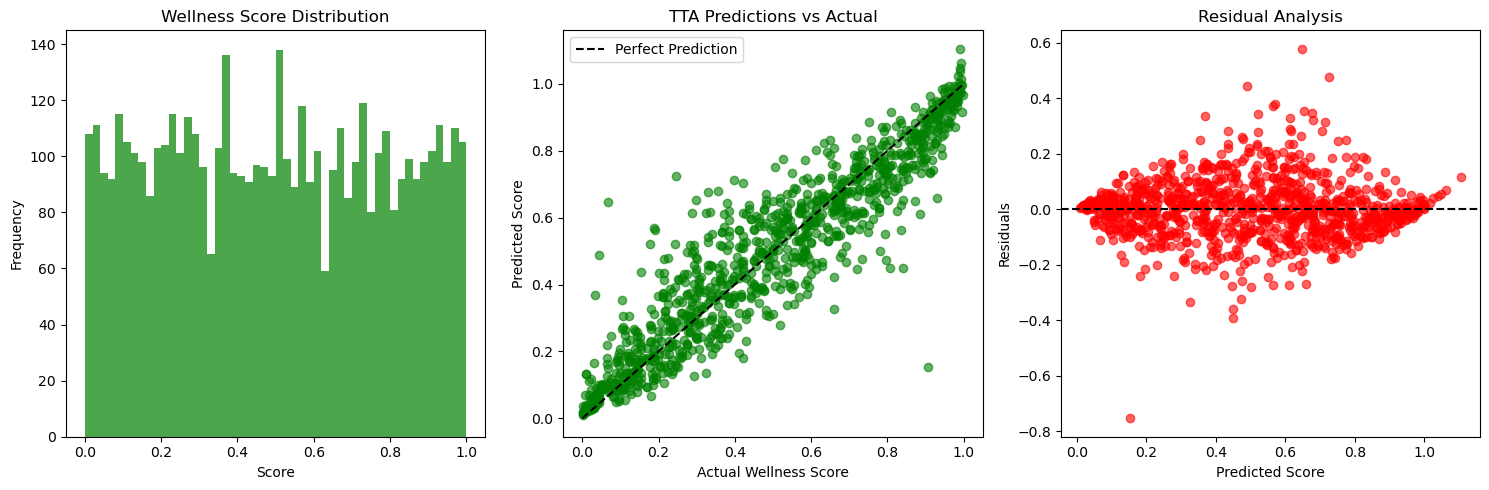


🏥 WELLNESS ORACLE INSIGHTS:
   • Training samples: 5,000
   • Score variance: 0.0844
   • Mean absolute error: 0.0781
   • 95% prediction within: ±0.2120
   • Challenging cases: 100 (10.0%)
   • Challenging score range: 0.034 - 0.930

💡 WELLNESS OPTIMIZATION RECOMMENDATIONS:
   • Focus on low-score wellness patterns (parks, open spaces)
   • Consider wellness-specific features:
     - Park accessibility from residential areas
     - Green space connectivity
     - Residential density optimization
     - Commercial-residential balance


In [12]:
# Advanced Wellness-Specific Analysis and Optimization
print("🏥 WELLNESS-SPECIFIC ANALYSIS")
print("="*60)

# Analyze wellness score patterns
import matplotlib.pyplot as plt

# Score distribution analysis
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(ratings_subset, bins=50, alpha=0.7, color='green')
plt.title('Wellness Score Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.scatter(y_test, preds_test_tta, alpha=0.6, color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Perfect Prediction')
plt.title('TTA Predictions vs Actual')
plt.xlabel('Actual Wellness Score')
plt.ylabel('Predicted Score')
plt.legend()

plt.subplot(1, 3, 3)
residuals = preds_test_tta - y_test
plt.scatter(preds_test_tta, residuals, alpha=0.6, color='red')
plt.axhline(y=0, color='k', linestyle='--')
plt.title('Residual Analysis')
plt.xlabel('Predicted Score')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

# Wellness-specific insights
print(f"\n🏥 WELLNESS ORACLE INSIGHTS:")
print(f"   • Training samples: {len(grids_subset):,}")
print(f"   • Score variance: {np.var(ratings_subset):.4f}")
print(f"   • Mean absolute error: {np.mean(np.abs(residuals)):.4f}")
print(f"   • 95% prediction within: ±{np.percentile(np.abs(residuals), 95):.4f}")

# Identify challenging wellness cases
challenging_mask = np.abs(residuals) > np.percentile(np.abs(residuals), 90)
print(f"   • Challenging cases: {np.sum(challenging_mask)} ({np.sum(challenging_mask)/len(residuals)*100:.1f}%)")

if np.sum(challenging_mask) > 0:
    challenging_scores = y_test[challenging_mask]
    print(f"   • Challenging score range: {challenging_scores.min():.3f} - {challenging_scores.max():.3f}")
    
    # Wellness-specific recommendations
    print(f"\n💡 WELLNESS OPTIMIZATION RECOMMENDATIONS:")
    if np.mean(challenging_scores) < 0.5:
        print(f"   • Focus on low-score wellness patterns (parks, open spaces)")
    else:
        print(f"   • Focus on high-score wellness patterns (residential balance)")
        
    print(f"   • Consider wellness-specific features:")
    print(f"     - Park accessibility from residential areas")
    print(f"     - Green space connectivity")
    print(f"     - Residential density optimization")
    print(f"     - Commercial-residential balance")